## Feature Development Extraction: Neurophysiology [dyskinesia project]




<b> Content </b>


<b> Aperiodic estimates </b>
Relevant literature:
- Periodic and a-periodic components relevance and interaction, different reasons (per + a-per) for signal changes observed within a specific bandwidth. Aperiodic component (complicated) vs exponent (1/f) (Donoghue, ..., Shestyuk & Voytek, Nature Neurosc 2020 : https://www.nature.com/articles/s41593-020-00744-x)
- cycle-by-cycle features: bycycle toolbox (Cole & Voytek, J of Neurophys 2019, https://journals.physiology.org/doi/full/10.1152/jn.00273.2019)
- aperiodic component, PD severity, and cortico-subcortico-activity, Bush & Zou, Richardson, bioRxiv 2023 https://www.biorxiv.org/content/10.1101/2023.02.08.527719v1?rss=1

<b> Periodic component analysis: </b> 
- Try Wavelet Dceomposition vs Welch (tapered) Spectral Decomposition





### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
from scipy.stats import pearsonr, mannwhitneyu

import matplotlib.pyplot as plt
from  matplotlib import __version__ as plt_version
from scipy import signal, stats
# from array import array
# import datetime as dt
# #mne
# import mne_bids
# import mne


In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
# print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
print('matplotlib', plt_version)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
sci-kit learn 1.1.3
matplotlib 3.5.3


In [3]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [4]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')

In [5]:
os.chdir(codepath)
# own utility functions
import utils.utils_fileManagement as utilsFiles
import utils.utils_windowing as utilsWindows
from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
import lfpecog_preproc.preproc_filters as fltrs
# own data exploration functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_features.feats_spectral_baseline as specBase
import lfpecog_features.feats_spectral_features as spectral
import lfpecog_features.feats_spectral_helpers as specHelp
import lfpecog_features.feats_helper_funcs as ftHelp

import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.import_ephys_results as importResults
# import lfpecog_analysis.get_acc_derivs as accDerivs


import lfpecog_plotting.plotHelpers as plotHelp

Check and Plot CDRS scores from both raters

In [ ]:
import traces
import datetime as dt

In [ ]:
max_scores_bilat = []
max_scores_ecoglat = []
rater='Patricia'

for s in ['008', '009', '010', '012',
             '013', '014', '016', '017']:

    t, scores = importClin.get_cdrs_specific(
        sub=s, rater=rater, side='both')
    max_scores_bilat.append(np.nanmax(scores))

    t, scores = importClin.get_cdrs_specific(
        sub=s, rater=rater, side='contra ecog')
    max_scores_ecoglat.append(np.nanmax(scores))

print('BILATERAL', max_scores_bilat, np.mean(max_scores_bilat))
print('ECoG lat.', max_scores_ecoglat, np.mean(max_scores_ecoglat))

In [ ]:
importlib.reload(importClin)
# CHECK CLINICAL RATINGS
subs_incl = ['008', '009', '010', '012',
             '013', '014', '016']

clrs = colors
styles = ['solid', 'dotted']
fig, axes = plt.subplots(1,1, figsize=(12, 6))

for i_sub, sub in enumerate(subs_incl):
    reg_t, reg_scores = {}, {}
    for i_r, rater in enumerate(['Patricia', 'Jeroen']):
        t, scores = importClin.get_cdrs_specific(sub=sub, rater=rater)
        axes.plot(t, scores,  # [0]
                color=clrs[i_sub], ls=styles[i_r], lw=3, label=f'{sub} ({rater})')

        # regularize scores
        reg_t[i_r], reg_scores[i_r] = importClin.get_cdrs_specific(
            sub=sub, rater=rater, regularize=True,)
        # axes[1].plot(reg_t[i_r], reg_scores[i_r],
        #         color=clrs[i_sub], ls=styles[i_r], lw=3, )
    
    # calculate correlations
    # only take minutes present in both scores
    t_start = max([reg_t[i_r][0] for i_r in [0, 1]])
    t_stop = min([reg_t[i_r][-1] for i_r in [0, 1]])
    sel0 = [time >= t_start and time <= t_stop for time in reg_t[0]]
    sel1 = [time >= t_start and time <= t_stop for time in reg_t[1]]
    
    print(sub, pearsonr(reg_scores[0][sel0], reg_scores[1][sel1]))

# axes[0].set_title('Inserted scores per timepoint', size=14)
# axes[1].set_title('Interpolated scores (per 1 minute)', size=14)
handles, labels = axes.get_legend_handles_labels()
plt.legend(handles, labels, ncol=5, bbox_to_anchor=(.5, -.25),
               loc='upper center', fontsize=14,)
# for ax in axes:
axes.set_ylabel('CDRS score', fontsize=14)
axes.set_xlabel('Time (minutes vs LDOPA-intake)', fontsize=14)
axes.tick_params(axis='both', labelsize=14, size=14)

plt.tight_layout()
# figname = 'CDRS_scores_2rater_interpolation'
# plt.savefig(os.path.join(figpath, 'clinical_scores', figname), dpi=150,
#             facecolor='w',)
# figname = 'CDRS_scores_2raters'
# plt.savefig(os.path.join(figpath, 'clinical_scores', figname), dpi=150,
#             facecolor='w',)
plt.close()




### 1. Load preprocessed and merged Sub-Data

#### load ACC pickles

In [ ]:
subs_to_plot = [
    '008', 
    # '009', '010', '012', 
    # '013', '014', '016'
]

data_version = 'v4.0'
mins_recording = []

for sub in subs_to_plot:
    # load Acc-detected movement labels
    acc = load_class_pickle(os.path.join(
        get_project_path('data'),
        'merged_sub_data', data_version, f'sub-{sub}',
        f'{sub}_mergedData_{data_version}_accLeft.P'
    ))
    # acc = correct_acc_class(acc)

    # mins_recording.append(acc.data.shape[0] / acc.fs / 60)

#### load ephys pickle

WINDOWED DATA

In [ ]:
subs_to_plot = [
    # '008', '009', '010', '012', 
    # '013', '014',
    '012',
]
task = 'rest'
data_version = 'v3.0'
mins_recording = []

# for sub in subs_to_plot:
#     # load Acc-detected movement labels
#     data = load_class_pickle(os.path.join(
#         get_project_path('data'), 'windowed_data_classes_60s',
#         data_version, f'sub-{sub}', task,
#         f'{sub}_mneEpochs_{task}_{data_version}_win60s_overlap0.5.P'
#     ))
#     # acc = correct_acc_class(acc)


In [ ]:
data.list_mne_objects[0].times.shape

data.list_mne_objects[0].ch_names

data.list_mne_objects[0].get_data().shape

MERGED DATA per DATATYPE (source)


In [ ]:
# LOAD TASK DATA BEFORE MERGING
sub = '019'
data_version = 'v4.0'
dType = 'ecog_right'

path = os.path.join(get_project_path('data'),
                    'preprocessed_data',
                    f'sub-{sub}', 'v4.0',)
f_data = f'data_{sub}_Rest_StimOffDopa35_{data_version}_{dType}_2048Hz.npy'
c_data = f'names_{sub}_Rest_StimOffDopa35_{data_version}_{dType}.csv'

d = np.load(os.path.join(path, f_data))
cols = pd.read_csv(os.path.join(path, c_data))

In [ ]:
# LOAD MERGED PICKLE
subs_incl = [
    '013', 
    # '009', '010', '012', 
    # '013', '014',
    # '012',
]
# task = 'rest'
data_version = 'v4.0'

# for sub in subs_incl:
#     # load merged data class
#     data = load_class_pickle(os.path.join(
#         get_project_path('data'), 'merged_sub_data',
#         data_version,
#         f'{sub}_mergedDataClass_{data_version}.P'
#     ))

In [ ]:
sub = '019'
dat = {}
dType = 'lfp_right'
dat[dType] = load_class_pickle(os.path.join(
        get_project_path('data'), 'merged_sub_data',
        'v4.0', f'sub-{sub}',
        f'{sub}_mergedData_{data_version}_{dType}.P'))

Load windows

In [ ]:
ephys_sources = ['ecog_right', ]  #'lfp_right', 'ecog_left', 'ecog_right']
use_stored_windows = True

sub = '019'
json_path = os.path.join(utilsFiles.get_onedrive_path('data'),
                     'featureExtraction_jsons',
                     'ftExtr_spectral_v5.json')
with open(json_path, 'r') as json_data:
    SETTINGS = json.load(json_data)

windows_path = os.path.join(utilsFiles.get_project_path('data'),
                    'windowed_data_classes_'
                    f'{SETTINGS["WIN_LEN_sec"]}s_'
                    f'{SETTINGS["WIN_OVERLAP_part"]}overlap',
                    SETTINGS['DATA_VERSION'],
                    f'sub-{sub}')

In [ ]:
windows = {}
for dType in ephys_sources:
    print(f'\tstart {dType}')
    # define path for windows of dType
    dType_fname = (f'sub-{sub}_windows_'
                    f'{SETTINGS["WIN_LEN_sec"]}s_'
                    f'{SETTINGS["DATA_VERSION"]}_{dType}.P')
    dType_win_path = os.path.join(windows_path, dType_fname)
    
    # check if windows are already available
    if np.logical_and(use_stored_windows,
                        os.path.exists(dType_win_path)):
        print(f'load data from {windows_path}....')
        windows[dType] = utilsFiles.load_class_pickle(dType_win_path)
        print(f'\tWINDOWS LOADED from {dType_fname} in {windows_path}')

### Plot ssd'd Spectral Descriptives

In [6]:
import lfpecog_features.get_ssd_data as ssd
import lfpecog_analysis.ft_processing_helpers as ftProc
import lfpecog_analysis.get_SSD_timefreqs as ssd_TimeFreq
import lfpecog_plotting.plot_timeFreqs_ssd_psds as plot_ssd_TFs

In [7]:
def get_avail_ssd_subs(
    DATA_VERSION, FT_VERSION,
    IGNORE_PTS=[],
    INCL_STN_ONLY_PTS=True,
    WIN_LEN=10, WIN_OVERLAP=.5,
    SSD_BROAD=True, 
):
# get all available subs with features

    ssd_folder = 'SSD_feats'
    if SSD_BROAD: ssd_folder += '_broad'
    ssd_folder += f'_{FT_VERSION}'
    ssd_path = os.path.join(get_project_path('results'), 'features',
                            ssd_folder, DATA_VERSION,
                            f'windows_{WIN_LEN}s_'
                            f'{WIN_OVERLAP}overlap')
    SUBS = list(set([name.split('_')[1]
                    for name in os.listdir(ssd_path)]))

    # remove ignore patients and e.g. STN onlys
    remove_subs = []
    if not INCL_STN_ONLY_PTS:
        for sub in SUBS:
            if sub.startswith('1'): remove_subs.append(sub)

    for sub in IGNORE_PTS + remove_subs:
        if sub in SUBS: SUBS.remove(sub)

    return SUBS

Plot SSD construction overview

In [ ]:
### PLOT VISUAL SSD OVERVIEW

# # loop over defined frequency bands
# for bw in SETTINGS['SPECTRAL_BANDS']:
#     f_range = SETTINGS['SPECTRAL_BANDS'][bw]
    # check whether to perform SSD
    # (ssd_filt_data,
    #     ssd_pattern,
    #     ssd_eigvals
    # ) = ssd.get_SSD_component(
    #     data_2d=win_dat.T,
    #     fband_interest=f_range,
    #     s_rate=windows.fs,
    #     use_freqBand_filtered=True,
    #     return_comp_n=0,
    # )

#     f, psd = signal.welch(ssd_filt_data, axis=-1,
#                     nperseg=windows.fs, fs=windows.fs)
#     plt.plot(f, psd, label=bw)

        

# plt.xlim(0, 100)
# plt.title(f'WINDOW # {i_w} - {dType.upper()}')
# plt.legend()
# plt.show()

#### SSD time freq plotting


In [8]:
# get windowed bands of different dtypes per sub
importlib.reload(ftHelp)
importlib.reload(ssd)
importlib.reload(ssd_TimeFreq)

sub = '022'

# call from feats_extract_multivar.py
ssd_subClass = ssd.get_subject_SSDs(
    sub=sub,
    incl_stn=True,
    incl_ecog=True,
    ft_setting_fname='ftExtr_spectral_v6.json',)





	subject 110 has STN ONLY recordings
load windowed ssd c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-110\broadSSD_windowedBands_110_lfp_left_v6.json c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-110\broadSSD_windowedBands_110_lfp_left_v6.npy
	...loaded SSD windowed-data and meta-info for lfp_left of sub-110
load windowed ssd c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-110\broadSSD_windowedBands_110_lfp_right_v6.json c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-110\broadSSD_windowedBands_110_lfp_right_v6.npy
	...loaded SSD windowed-data and meta-info for lfp_right of sub-110


In [ ]:
# def get_timeFreq_xticks(x_times):
#     """
#     Input:
#         - xticks given in seconds
    
#     Returns:
#         - xticks
#         - xticklabels (in minutes)
#     """
#     # define first and last tick rounded on 10 minutes
#     first_xtick = np.ceil((x_times / 60 / 10)[0]) * 10
#     last_xtick = np.floor((x_times / 60 / 10)[-1]) * 10
#     # get ticklabels in 10 minute spacing
#     xticklabels = np.arange(first_xtick, last_xtick+1, 10).astype(int)
#     # find nearest indices in x_times for created labels
#     xticks = np.array([np.argmin(abs(x_times/60 - t)) for t in xticklabels])
#     # drop ticks and labels if they are too close (visually overwrite each other)
#     drop_close_ticks = np.append(np.array([False]), np.diff(xticks) < 150)
#     # drop too close ticks, labels
#     xticklabels = xticklabels[~drop_close_ticks]
#     xticks = xticks[~drop_close_ticks]

#     return xticks, xticklabels

In [9]:
WIN_LEN=10
WIN_OVERLAP=0.5
DATA_VERSION='v4.0'
FT_VERSION='v6'
SSD_BROAD=True
INCL_STN_ONLY_PTS=True
IGNORE_PTS=['011', '104', '106']

In [ ]:
dat = ssd_TimeFreq.get_SSD_timeFreq(sub=sub, DATA_VERSION=DATA_VERSION,
                                      FT_VERSION=FT_VERSION,)

In [10]:
importlib.reload(ssd_TimeFreq)
importlib.reload(ftProc)
importlib.reload(importClin)
importlib.reload(ssd_TimeFreq)
importlib.reload(plot_ssd_TFs)

# CONVERT ONLY STNS!!!!!
SUBS = get_avail_ssd_subs(DATA_VERSION=DATA_VERSION,
                          FT_VERSION=FT_VERSION,
                          IGNORE_PTS=IGNORE_PTS)
print(SUBS)

for sub in SUBS:
    if sub not in ['022', '110']:
        print(f'skip {sub}')
        continue
    # try:
    print(f'PLOT SUB-{sub}')
    plot_ssd_TFs.plot_indiv_ssd_timefreq_allSources(
        sub, fig_name_base='0920_ssdTimeFreq',
        FT_VERSION=FT_VERSION,
        ZSCORE=False, LOG_POWER=True,
        SAVE_PLOT=True)
    # except:
    #     print(f'sub {sub} error')

['108', '109', '017', '110', '101', '102', '107', '019', '014', '016', '013', '021', '009', '022', '012', '008', '020', '103', '010', '105']
skip 108
skip 109
skip 017
PLOT SUB-110
START CREATING SSD PSDs for sub-110 (fts: v6) in get_SSD_timeFreq()

	subject 110 has STN ONLY recordings
load windowed ssd c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-110\broadSSD_windowedBands_110_lfp_left_v6.json c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-110\broadSSD_windowedBands_110_lfp_left_v6.npy
	...loaded SSD windowed-data and meta-info for lfp_left of sub-110
load windowed ssd c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-110\broadSSD_windowedBands_110_lfp_right_v6.json c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-110\broadSSD_windowedBands_110_lfp_rig

#### SSD PSD plotting

In [11]:
import lfpecog_plotting.plot_descriptive_SSD_PSDs as plot_PSDs

In [12]:
WIN_LEN=10
WIN_OVERLAP=0.5
DATA_VERSION='v4.0'
FT_VERSION='v6'
SSD_BROAD=True
INCL_STN_ONLY_PTS=True
IGNORE_PTS=['011', '104', '106']

In [13]:
SUBS = get_avail_ssd_subs(DATA_VERSION=DATA_VERSION,
                          FT_VERSION=FT_VERSION,
                          IGNORE_PTS=IGNORE_PTS)
print(SUBS)
print(len(SUBS))

['108', '109', '017', '110', '101', '102', '107', '019', '014', '016', '013', '021', '009', '022', '012', '008', '020', '103', '010', '105']
20


In [14]:
importlib.reload(ssd_TimeFreq)


TFs = ssd_TimeFreq.get_all_ssd_timeFreqs(
    SUBS=SUBS, FT_VERSION=FT_VERSION
)


load existing powers for sub-108 (fts: v6, SSD_PSD_108.json)
...loaded subject-108 Time-Frequency data
load existing powers for sub-109 (fts: v6, SSD_PSD_109.json)
...loaded subject-109 Time-Frequency data
load existing powers for sub-017 (fts: v6, SSD_PSD_017.json)
...loaded subject-017 Time-Frequency data
load existing powers for sub-110 (fts: v6, SSD_PSD_110.json)
...loaded subject-110 Time-Frequency data
load existing powers for sub-101 (fts: v6, SSD_PSD_101.json)
...loaded subject-101 Time-Frequency data
load existing powers for sub-102 (fts: v6, SSD_PSD_102.json)
...loaded subject-102 Time-Frequency data
load existing powers for sub-107 (fts: v6, SSD_PSD_107.json)
...loaded subject-107 Time-Frequency data
load existing powers for sub-019 (fts: v6, SSD_PSD_019.json)
...loaded subject-019 Time-Frequency data
load existing powers for sub-014 (fts: v6, SSD_PSD_014.json)
...loaded subject-014 Time-Frequency data
load existing powers for sub-016 (fts: v6, SSD_PSD_016.json)
...loaded su

In [ ]:
# '016' : check why short peak of CDRS 3 at beginning of LID?


##### Plot Group Results: Spectral changes over Time after L-Dopa, non-LID versus LID

In [15]:
# make groups with and without occurence of LID
subs_LID = []
subs_noLID = []

for sub in SUBS:
    print(f'check sub-{sub}')
    if sub in IGNORE_PTS:
        
        print(f'skip sub-{sub}')
        continue
    try:
        max_score = max(ftProc.get_cdrs_specific(sub=sub,
                                                rater='Jeroen',
                                                side='both')[1])
        if max_score > 0: subs_LID.append(sub)
        else: subs_noLID.append(sub)
    except ValueError:
        print(f'sub-{sub} not included, no CDRS scores')

check sub-108
check sub-109
check sub-017
check sub-110
check sub-101
check sub-102
check sub-107
check sub-019
check sub-014
check sub-016
check sub-013
check sub-021
check sub-009
check sub-022
check sub-012
check sub-008
check sub-020
check sub-103
check sub-010
check sub-105


In [17]:
importlib.reload(plot_PSDs)

# PM, needs: TFs = ssd_TimeFreq.get_all_ssd_timeFreqs(SUBS=SUBS)

SAVE=True
SHOW=False

SAVE_DATE = '0920'
STN_or_ECOG='STN'
ZSCORE_FREQS=False
SMOOTH_FREQS=8
LOG_POWER=False
BASELINE_CORRECT=True

n_subs_incl = len(subs_LID) + len(subs_noLID)

fig_name = f'{SAVE_DATE}_{STN_or_ECOG}_PSDs_noLID_LID_vs_DopaTime_n{n_subs_incl}'
if BASELINE_CORRECT: fig_name += '_blCorrPrc'
if ZSCORE_FREQS: fig_name += '_Z'
if LOG_POWER: fig_name += '_log'
if SMOOTH_FREQS > 0: fig_name += f'_smooth{SMOOTH_FREQS}'




# plot_PSD_vs_DopaTime(TFs['008']['lfp_left'])
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fsize=20

# if None returned, dont use axes[0] to collect returned output
if STN_or_ECOG == 'STN': ax_title = 'Bilateral STNs w/o Dyskinesia'
elif STN_or_ECOG == 'ECOG': ax_title = 'ECoG w/o Dyskinesia'
axes[0] = plot_PSDs.plot_PSD_vs_DopaTime(
    TFs, sel_subs=subs_noLID,
    STN_or_ECOG=STN_or_ECOG,
    BASELINE_CORRECT=BASELINE_CORRECT,
    ZSCORE_FREQS=ZSCORE_FREQS,
    LOG_POWER=LOG_POWER,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    plt_ax_to_return=axes[0], fsize=fsize, BREAK_X_AX=True,
    ax_title=ax_title
)


if STN_or_ECOG == 'STN': ax_title = 'Bilateral STNs with Dyskinesia'
elif STN_or_ECOG == 'ECOG': ax_title = 'ECoG with Dyskinesia'
axes[1] = plot_PSDs.plot_PSD_vs_DopaTime(
    TFs, sel_subs=subs_LID,
    STN_or_ECOG=STN_or_ECOG,
    LOG_POWER=LOG_POWER,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    BASELINE_CORRECT=BASELINE_CORRECT,
    ZSCORE_FREQS=ZSCORE_FREQS,
    plt_ax_to_return=axes[1], fsize=fsize, BREAK_X_AX=True,
    ax_title=ax_title
)




# equalize axes
ymin = min([min(ax.get_ylim()) for ax in axes])
ymax = max([max(ax.get_ylim()) for ax in axes])
for ax in axes: ax.set_ylim(ymin, ymax)

for ax in axes: ax.tick_params(axis='both', size=fsize,
                               labelsize=fsize)
plt.tight_layout()

if SAVE:
    path = os.path.join(get_project_path('figures'),
                        'ft_exploration',
                        f'data_{DATA_VERSION}_ft_{FT_VERSION}',
                        'descr_PSDs')
    if not os.path.exists(path): os.makedirs(path)
    plt.savefig(os.path.join(path, fig_name),
                facecolor='w', dpi=300,)
if SHOW: plt.show()
else: plt.close()



STN, t=15 (1) is n=8
STN, t=30 (2) is n=8
STN, t=45 (3) is n=6
STN, t=60 (4) is n=8
STN, t=75 (5) is n=2
STN, t=15 (1) is n=32
STN, t=30 (2) is n=32
STN, t=45 (3) is n=32
STN, t=60 (4) is n=30
STN, t=75 (5) is n=12


##### Plot LID-Group Results: Laterality of LID in STN and ECoG

Plot SEVERITY AND LATERALITY OF STN-changes during DYSKINESIA

- LAT_UNI: plot laterality of unilateral LID
- LAT_BILAT: plot laterality of only bilateral LID
- SCALE: combine all uni- and bilateral LID
    - PLOT_ONLY_MATCH == True: plot only STN contralateral to LID
    - PLOT_ONLY_MATCH == False: plot contra-, ipsi-, and bi-lateral STN-LID


In [18]:
import lfpecog_analysis.psd_lid_stats as psd_stats

In [20]:

importlib.reload(psd_stats)
importlib.reload(plot_PSDs)

# PM, needs: TFs = ssd_TimeFreq.get_all_ssd_timeFreqs(SUBS=SUBS)

# 'LAT_UNI' , 'LAT_BILAT', 'SCALE', 'LAT_ALL_SCALE'
LAT_or_SCALE = 'SCALE'
SAVE_DATE = '0920'

INCL_PRELID = False
PRELID_MINs=5
SMOOTH_FREQS=8
LOG_POWER=False
BASELINE_CORRECT=True
ZSCORE_FREQS=False
SHOW_GAMMA = False
SHOW_SIGN = True
PLOT_ONLY_MATCH = True

fig_name = f'{SAVE_DATE}_STN_PSDs_{LAT_or_SCALE}_LID_n{len(subs_LID)}'

if INCL_PRELID: fig_name += f'_inclPre{PRELID_MINs}'
if BASELINE_CORRECT: fig_name += '_blCorr'
if LOG_POWER: fig_name += '_log'
if ZSCORE_FREQS: fig_name += '_Z'
if SMOOTH_FREQS > 0: fig_name += f'_smooth{SMOOTH_FREQS}'
# if SINGLE_LINE: fig_name += '_lines'
if SHOW_GAMMA: fig_name += '_GAMMA'
if SHOW_SIGN: fig_name += '_SIGN'
if PLOT_ONLY_MATCH: fig_name += '_onlyMatch'

fsize=14

stn_stats = plot_PSDs.plot_STN_PSD_vs_LID(
    TFs, sel_subs=subs_LID,
    CDRS_RATER='Jeroen',
    LAT_or_SCALE=LAT_or_SCALE,
    incl_PRE_LID=INCL_PRELID,
    PRELID_MIN=PRELID_MINs,
    LOG_POWER=LOG_POWER,
    BASELINE_CORRECT=BASELINE_CORRECT,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    ZSCORE_FREQS=ZSCORE_FREQS,
    plt_ax_to_return=False,
    fsize=fsize,
    BREAK_X_AX=True,
    fig_name=fig_name,
    RETURN_FREQ_CORR=False,
    SHOW_ONLY_GAMMA=SHOW_GAMMA,
    SHOW_SIGN=False,
    PROCESS_STATS=False,
    p_SAVED_DATE=SAVE_DATE,
    PLOT_ONLY_MATCH=PLOT_ONLY_MATCH,
    DATA_VERSION=DATA_VERSION,
    FT_VERSION=FT_VERSION,
)


start plotting 0920_STN_PSDs_SCALE_LID_n16_blCorr_smooth8_SIGN_onlyMatch


c:\Users\habetsj\Research\projects\dyskinesia_neurophys\code\lfpecog_plotting\plot_descriptive_SSD_PSDs.py:860: RuntimeWarning: Mean of empty slice
  PSD[k] = [np.nanmean(PSD[k][np.logical_and(idx > (i_v - s_win),


In [ ]:
import lfpecog_analysis.psd_lid_stats as psdLID_stats

Plot SEVERITY AND LATERALITY OF ECoG-changes during DYSKINESIA

In [22]:
# importlib.reload(psdLID_stats)
importlib.reload(plot_PSDs)

# PM, needs: TFs = ssd_TimeFreq.get_all_ssd_timeFreqs(SUBS=SUBS)

# 'LAT_UNI' , 'LAT_BILAT', 'SCALE', 'LAT_ALL_SCALE'
SAVE_DATE = '0920'
LAT_or_SCALE = 'SCALE'
SAVE_PLOT = True
SHOW_PLOT = False

SMOOTH_FREQS = 8
LOG_POWER = False
BASELINE_CORRECT = True
ZSCORE_FREQS = False
SINGLE_LINE = False
SHOW_GAMMA = False
PLOT_ONLY_MATCH = False
SHOW_SIGN = False

fig_name = f'{SAVE_DATE}_ECoG_PSDs_LID_{LAT_or_SCALE}_n{len(subs_LID)}'

if BASELINE_CORRECT: fig_name += '_blCorr'
if LOG_POWER: fig_name += '_log'
if ZSCORE_FREQS: fig_name += '_Z'
if SMOOTH_FREQS > 0: fig_name += f'_smooth{SMOOTH_FREQS}'
if SINGLE_LINE: fig_name += '_lines'
if SHOW_GAMMA: fig_name += '_GAMMA'
if SHOW_SIGN: fig_name += '_SIGN'
if PLOT_ONLY_MATCH: fig_name += '_onlyMatch'

fsize=14

plot_PSDs.plot_ECOG_PSD_vs_LID(
    TFs, sel_subs=subs_LID,
    LAT_or_SCALE=LAT_or_SCALE,
    LOG_POWER=LOG_POWER,
    BASELINE_CORRECT=BASELINE_CORRECT,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    ZSCORE_FREQS=ZSCORE_FREQS,
    plt_ax_to_return=False,
    fsize=fsize,
    BREAK_X_AX=True,
    fig_name=fig_name,
    single_sub_lines=SINGLE_LINE,
    PLOT_ONLY_MATCH=PLOT_ONLY_MATCH,
    SHOW_ONLY_GAMMA=SHOW_GAMMA,
    SHOW_SIGN=SHOW_SIGN,
    PROCESS_STATS=False,
    p_SAVED_DATE=SAVE_DATE,
    DATA_VERSION=DATA_VERSION,
    FT_VERSION=FT_VERSION,
)

c:\Users\habetsj\Research\projects\dyskinesia_neurophys\code\lfpecog_plotting\plot_descriptive_SSD_PSDs.py:860: RuntimeWarning: Mean of empty slice
  PSD[k] = [np.nanmean(PSD[k][np.logical_and(idx > (i_v - s_win),


Plot LATERALITY during UNILATERAL dyskinesia

In [23]:
importlib.reload(plot_PSDs)


SAVE_PLOT = True
SHOW_PLOT = False

SMOOTH_FREQS=8
LOG_POWER=False
BASELINE_CORRECT=True
ZSCORE_FREQS=False
CDRS_RATER = 'Jeroen'

fig_name = f'{SAVE_DATE}_LATERALITY_STNandECOG_PSDs_unilatLID_n{len(SUBS)}'
if BASELINE_CORRECT: fig_name += '_blCorr'
if LOG_POWER: fig_name += '_log'
if ZSCORE_FREQS: fig_name += '_Z'
if SMOOTH_FREQS > 0: fig_name += f'_smooth{SMOOTH_FREQS}'



fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fsize=14

plot_PSDs.plot_STN_PSD_vs_LID(
    TFs, sel_subs=subs_LID,
    LAT_or_SCALE='LAT_UNI',  # LAT_UNI
    CDRS_RATER=CDRS_RATER,
    LOG_POWER=LOG_POWER,
    BASELINE_CORRECT=BASELINE_CORRECT,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    ZSCORE_FREQS=ZSCORE_FREQS,
    plt_ax_to_return=axes[0],
    fsize=fsize,
    BREAK_X_AX=True,
    DATA_VERSION=DATA_VERSION,
    FT_VERSION=FT_VERSION,
)
plot_PSDs.plot_ECOG_PSD_vs_LID(
    TFs, sel_subs=subs_LID,
    LAT_or_SCALE='LAT_UNI',
    CDRS_RATER=CDRS_RATER,
    LOG_POWER=LOG_POWER,
    BASELINE_CORRECT=BASELINE_CORRECT,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    ZSCORE_FREQS=ZSCORE_FREQS,
    plt_ax_to_return=axes[1],
    fsize=fsize,
    BREAK_X_AX=True,
    DATA_VERSION=DATA_VERSION,
    FT_VERSION=FT_VERSION,
)

# equalize axes
ymin = min([min(ax.get_ylim()) for ax in axes])
ymax = max([max(ax.get_ylim()) for ax in axes])
for ax in axes: ax.set_ylim(ymin, ymax)

for ax in axes: ax.tick_params(axis='both', size=fsize,
                               labelsize=fsize)
plt.tight_layout()

if SAVE_PLOT:
    plt.savefig(os.path.join(get_project_path('figures'),
                             'ft_exploration',
                             f'data_{DATA_VERSION}_ft_{FT_VERSION}',
                             'descr_PSDs', fig_name),
                facecolor='w', dpi=300,)
if SHOW_PLOT: plt.show()
else: plt.close()

start plotting PLOT_STN_PSD_vs_DYSK


c:\Users\habetsj\Research\projects\dyskinesia_neurophys\code\lfpecog_plotting\plot_descriptive_SSD_PSDs.py:1035: RuntimeWarning: Mean of empty slice
  PSD[k] = [np.nanmean(PSD[k][np.logical_and(idx > (i_v - s_win),


skip sub-016, no uni-lateral dyskinesia
skip sub-012, no uni-lateral dyskinesia


c:\Users\habetsj\Research\projects\dyskinesia_neurophys\code\lfpecog_plotting\plot_descriptive_SSD_PSDs.py:1035: RuntimeWarning: Mean of empty slice
  PSD[k] = [np.nanmean(PSD[k][np.logical_and(idx > (i_v - s_win),


Plot PSDs versus categorical CDRS severity

In [ ]:
"""
STN SCALING shows only-contra; only-ipsilateral; merged-bilateral
"""

# importlib.reload(ftProc)
importlib.reload(plot_PSDs)

fig_name = f'1408_STN_PSD_CDRS_scaling_n{len(subs_LID + subs_noLID)}'

SAVE_PLOT = True
SHOW_PLOT = False

SMOOTH_FREQS=8
LOG_POWER=False
BASELINE_CORRECT=True
ZSCORE_FREQS=False
fsize=14

if BASELINE_CORRECT: fig_name += '_blCorr'
if LOG_POWER: fig_name += '_log'
if ZSCORE_FREQS: fig_name += '_Z'
if SMOOTH_FREQS > 0: fig_name += f'_smooth{SMOOTH_FREQS}'

# plot internally due to difficulties of returning multiple axes
plot_PSDs.plot_STN_PSD_vs_LID(
    TFs, sel_subs=subs_LID,
    LAT_or_SCALE='SCALE',
    LOG_POWER=LOG_POWER,
    BASELINE_CORRECT=BASELINE_CORRECT,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    ZSCORE_FREQS=ZSCORE_FREQS,
    # plt_ax_to_return=axes,
    fsize=fsize,
    BREAK_X_AX=True,
    fig_name=fig_name,
    SINGLE_SUB_LINES=False,
)


In [ ]:
"""
ECoG SCALE shows unilateral scaling and merged-bilateral scaling
"""


# importlib.reload(ftProc)
importlib.reload(plot_PSDs)


SAVE_PLOT = True
SHOW_PLOT = False

SMOOTH_FREQS=8
LOG_POWER=False
BASELINE_CORRECT=True
ZSCORE_FREQS=False
fsize=14
fig_name = f'1408_ECOG_PSD_CDRS_scaling_n{len(subs_LID + subs_noLID)}'

if BASELINE_CORRECT: fig_name += '_blCorr'
if LOG_POWER: fig_name += '_log'
if ZSCORE_FREQS: fig_name += '_Z'
if SMOOTH_FREQS > 0: fig_name += f'_smooth{SMOOTH_FREQS}'

# plot internally due to difficulties of returning multiple axes
plot_PSDs.plot_ECOG_PSD_vs_LID(
    TFs, sel_subs=subs_LID,
    LAT_or_SCALE='SCALE',
    LOG_POWER=LOG_POWER,
    BASELINE_CORRECT=BASELINE_CORRECT,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    ZSCORE_FREQS=ZSCORE_FREQS,
    # plt_ax_to_return=axes,
    fsize=fsize,
    BREAK_X_AX=True,
    fig_name=fig_name,
    DATA_VERSION=DATA_VERSION,
    FT_VERSION=FT_VERSION,
)

#### Plot Frequency-Correlation Plots


Use subject-specific gamma peak frequencies, or sums of 60 - 90 Hz, be careful with per freq-bin analysis due to differences in peak-freqs

In [105]:
importlib.reload(plot_PSDs)

# PM, needs: TFs = ssd_TimeFreq.get_all_ssd_timeFreqs(SUBS=SUBS)

LAT_or_SCALE = 'LAT_BILAT'
RETURN_FREQ_CORR = True
SAVE_DATE = '0914'

SMOOTH_FREQS=8
LOG_POWER=False
BASELINE_CORRECT=True
ZSCORE_FREQS=False

fig_name = f'{SAVE_DATE}_FREQCORR_STN_PSDs_{LAT_or_SCALE}_LID_n{len(SUBS)}'

if BASELINE_CORRECT: fig_name += '_blCorr'
if LOG_POWER: fig_name += '_log'
if ZSCORE_FREQS: fig_name += '_Z'
if SMOOTH_FREQS > 0: fig_name += f'_smooth{SMOOTH_FREQS}'

fsize=14

FrqCor = plot_PSDs.plot_STN_PSD_vs_LID(
    TFs, sel_subs=subs_LID,
    LAT_or_SCALE=LAT_or_SCALE,
    LOG_POWER=LOG_POWER,
    BASELINE_CORRECT=BASELINE_CORRECT,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    ZSCORE_FREQS=ZSCORE_FREQS,
    plt_ax_to_return=False,
    fsize=fsize,
    BREAK_X_AX=True,
    fig_name=fig_name,
    RETURN_FREQ_CORR=RETURN_FREQ_CORR,
    DATA_VERSION=DATA_VERSION,
    FT_VERSION=FT_VERSION,
)
# FrqCorr

start plotting 0914_FREQCORR_STN_PSDs_LAT_BILAT_LID_n18_blCorr_smooth8
skip sub-010 during LAT_BILAT, no BILATERAL LID
skip sub-108 during LAT_BILAT, no BILATERAL LID
skip sub-014 during LAT_BILAT, no BILATERAL LID
not plotting, only returning freq corr values


In [ ]:
# importlib.reload(psdLID_stats)

# datatype = 'STN'
# store_path = os.path.join(get_project_path('results'), 'stats',
#                           f'data_{DATA_VERSION}_ft_{FT_VERSION}',
#                           f'{datatype}_LMM_noLID_vs_LID')

# plist = psdLID_stats.get_binary_p_perHz(datatype='STN',
#                                         load_data=True,
#                                         save_date=SAVE_DATE,
#                                         return_full_dict=True,
#                                         FT_VERSION=FT_VERSION,
#                                         DATA_VERSION=DATA_VERSION)

In [124]:
def get_3d_freqCorr_arr(
    datatype='STN',
    BLOCK_LEN = 300,  # 5 minutes
    DATA_VERSION='v4.0',
    FT_VERSION='v6',
):
    store_path = os.path.join(get_project_path('results'), 'stats',
                              f'data_{DATA_VERSION}_ft_{FT_VERSION}',
                              f'{datatype}_LMM_noLID_vs_LID')
    total_freqs = []

    for i_f, f_hz in enumerate(np.arange(4, 90)):
        if f_hz > 35 and f_hz < 60:
            # print(f'skip {f_hz} Hz')
            continue

        df = pd.read_csv(os.path.join(store_path,
                         f'{datatype}_LMM_LID_PSD_{f_hz}Hz_df.xlsx'),
                    index_col=0,)
        statsubs = [s for s in np.unique(df['sub']) if '_match' in s]

        for i_s, s in enumerate(statsubs):

            sub_pows, sub_scores = [], []
            d = df[df['sub'] == s].reset_index(drop=True)
            # divide borders for timeblock dividing of features
            borders = [i for i in np.arange(0, len(d), BLOCK_LEN)] + [len(d)]
            for i1, i2 in zip(borders[:-1], borders[1:]):
                # take mean CDRS score in block
                sub_scores.append(np.mean(d['CDRS'][i1:i2]))
                # take mean power in block
                sub_pows.append(np.mean(d['mean_power'][i1:i2]))

            sub_arr = np.array([
                [s] * len(sub_pows),
                [i_s] * len(sub_pows),
                sub_scores, sub_pows
            ]).T
            if i_s == 0: f_arr = sub_arr
            else: f_arr = np.concatenate([f_arr, sub_arr], axis=0)

        if i_f == 0: total_arr = f_arr
        else: total_arr = np.dstack([f_arr, total_arr],)

        total_freqs.append(f_hz)

        # print(f'{f_hz} Hz, total shape: {total_arr.shape}')
            # print(s, sub_arr.shape, f_arr.shape)
            # plt.scatter(sub_scores, sub_pows)
            # plt.title(s)
            # plt.show()
    total_arr = total_arr.T
    print(f'{datatype}: total shape: {total_arr.shape}, length freqs: {len(total_freqs)}')

    return total_arr, total_freqs

In [122]:
from statsmodels.formula.api import mixedlm
import lfpecog_plotting.plot_FreqCorr as plt_FreqCorr

In [ ]:
def get_freqCorr_df(total_3d_arr, total_freqs=None, datatype='STN',
                    method='GLMM',):
    p_list, coeff_list = [], []
    if method == 'Pearson': coeff_err_list = []
    
    for i_f in np.arange(total_3d_arr.shape[0]):
        sub_strings = total_3d_arr[i_f, 0, :]
        sub_strings = list(np.unique(sub_strings))
        temp_df = pd.DataFrame(
            data=total_3d_arr[i_f, 1:, :].T,
            columns=['sub_idx', 'CDRS', 'pow']
        ).astype(np.float64)  # leave out string sub 'sub'

        if method == 'GLMM':
            model = mixedlm("pow ~ CDRS", temp_df,
                            groups=temp_df["sub_idx"])
            result = model.fit(method='lbfgs')
            # Extract the p-value for the Condition variable
            p_list.append(result.pvalues['CDRS'])
            coeff_list.append(result.fe_params['CDRS'])

        elif method == 'Pearson':
            f_Rs = []
            for i_s, sub in enumerate(np.unique(temp_df['sub_idx'].values)):
                dat = temp_df[temp_df['sub_idx'] == sub]
                R, p = pearsonr(dat['CDRS'], dat['pow'])
                f_Rs.append(R)
                          
                if total_freqs[i_f] in [75, 85]:
                    plt.scatter(dat['CDRS'], dat['pow'])
                    plt.title(f'{total_freqs[i_f]} Hz {sub_strings[i_s]} R: '
                              f'{round(R, 3)}, p: {round(p, 5)}')
                    plt.show()
                    
            coeff_list.append(np.nanmean(f_Rs))
            coeff_err_list.append(np.nanstd(f_Rs) / np.sqrt(len(f_Rs)))
            p_list.append(1)
            # TODO: p_list.append() fisher corrected test for means
                
    # print(result.summary())
    # plt.bar(x=total_freqs, height=coeff_list)
    
    if method == 'GLMM':
        df = pd.DataFrame(data=np.array([coeff_list, p_list]).T,
                          columns=['R', 'p'])
    elif method == 'Pearson':
        df = pd.DataFrame(data=np.array([coeff_list, p_list,
                                         coeff_err_list]).T,
                          columns=['R', 'p', 'R_stderr'])

    return df

In [127]:
# CALCULATES STN and ECOG Correlations based on stored PSD Dataframes per Hz-bin
BLOCK_SECS = 180
STAT_METHOD = 'Pearson'

total_arr, total_f = get_3d_freqCorr_arr(
    datatype='STN',
    BLOCK_LEN = BLOCK_SECS,  # 300 = 5 minutes
    DATA_VERSION=DATA_VERSION,
    FT_VERSION=FT_VERSION,
)
stn_df = get_freqCorr_df(total_3d_arr=total_arr, datatype='STN',
                         total_freqs=total_f,
                         method=STAT_METHOD)

ECOG: total shape: (62, 4, 197), length freqs: 62


c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scip

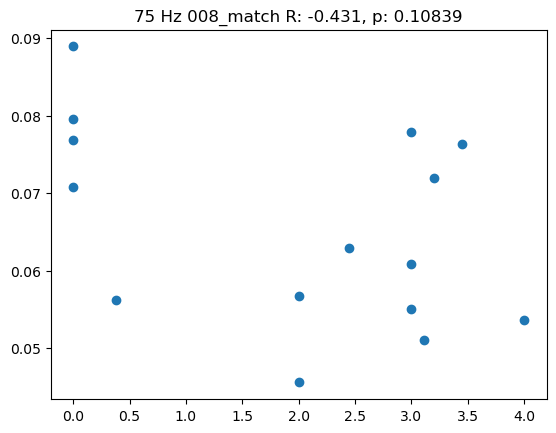

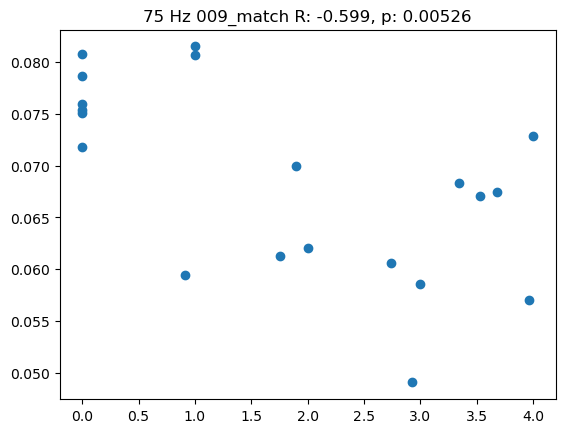

c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


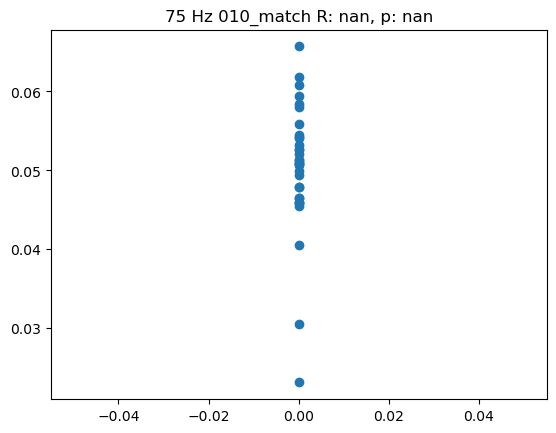

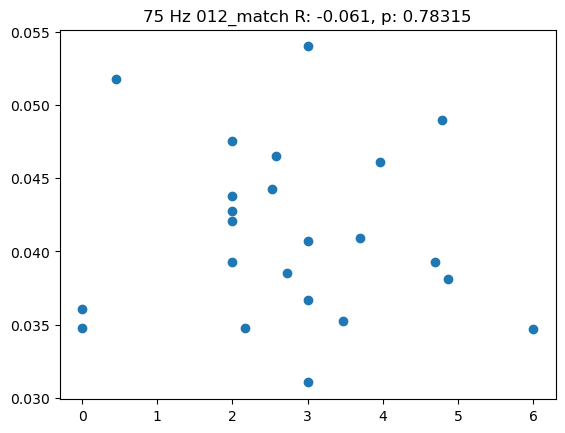

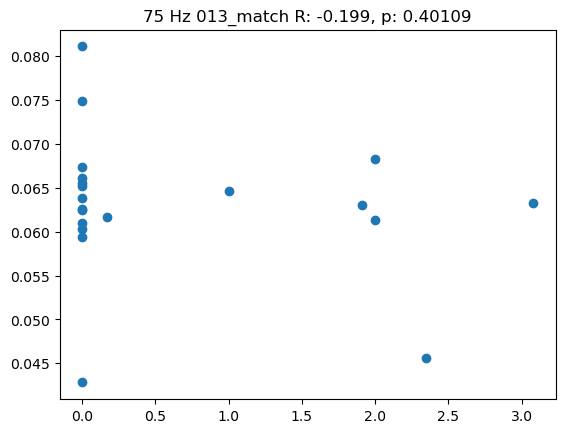

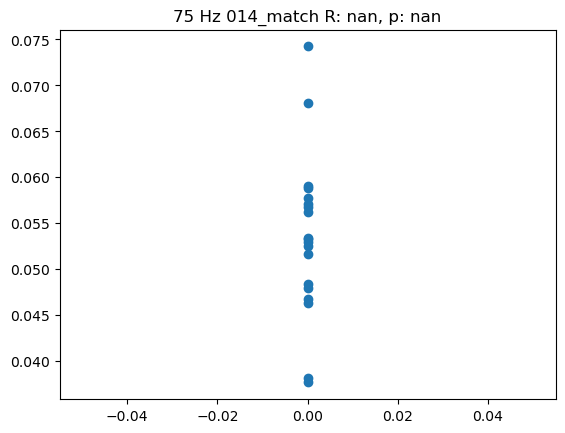

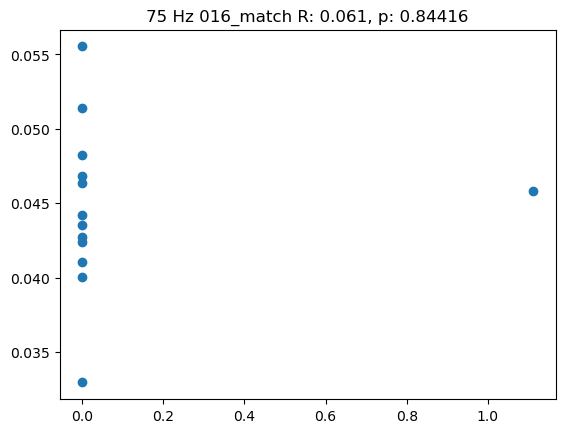

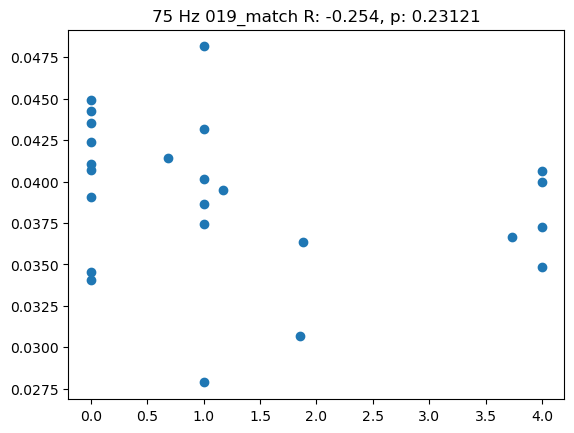

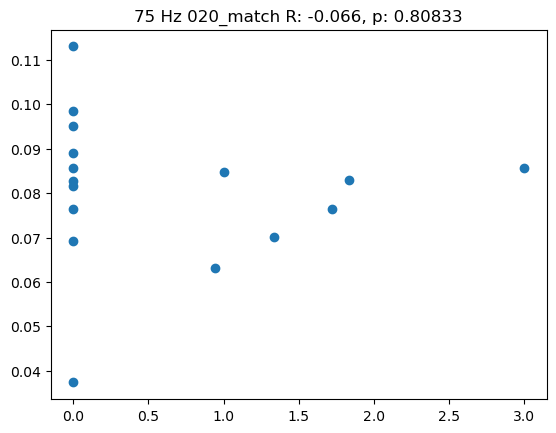

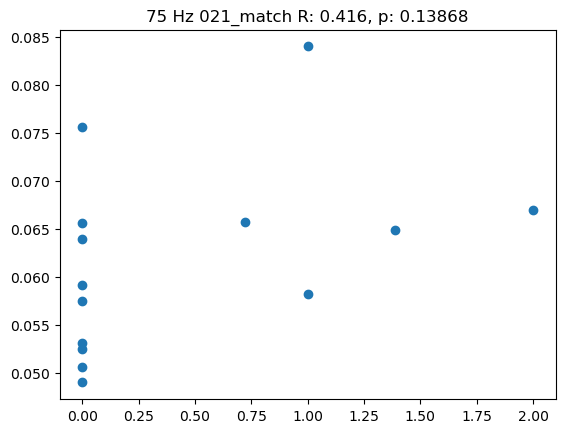

c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scip

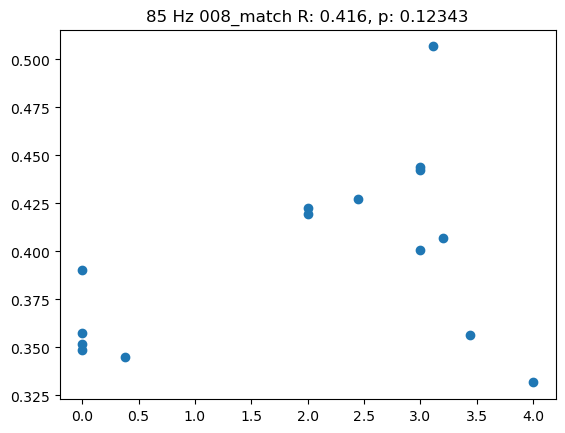

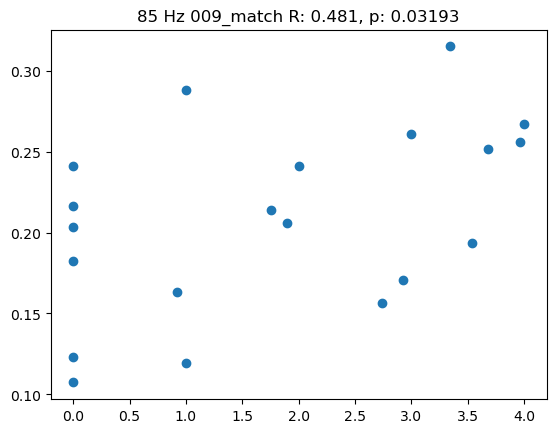

c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


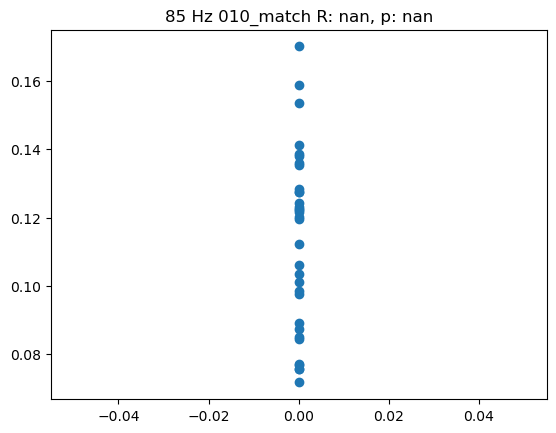

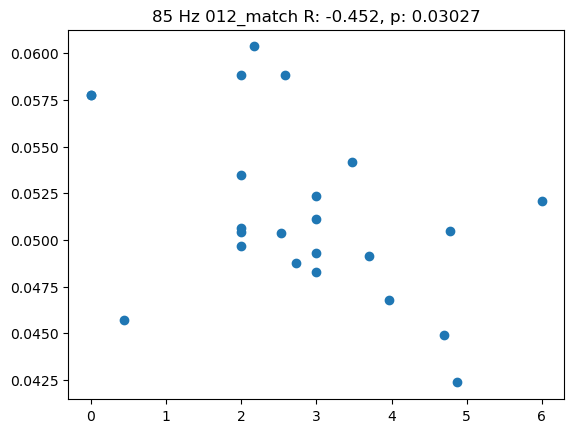

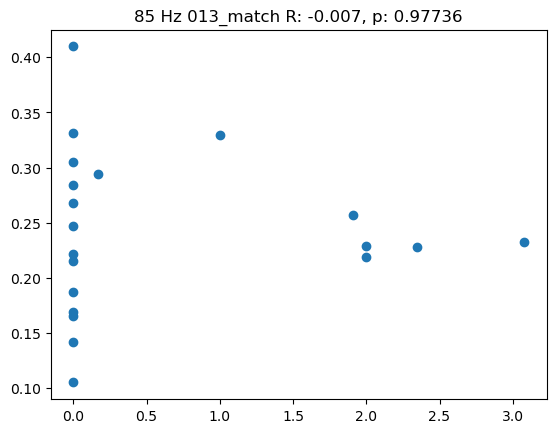

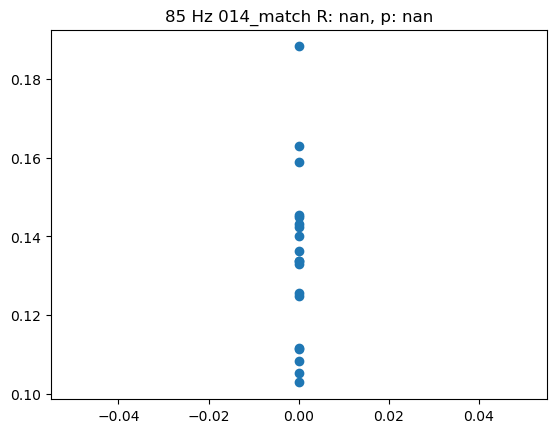

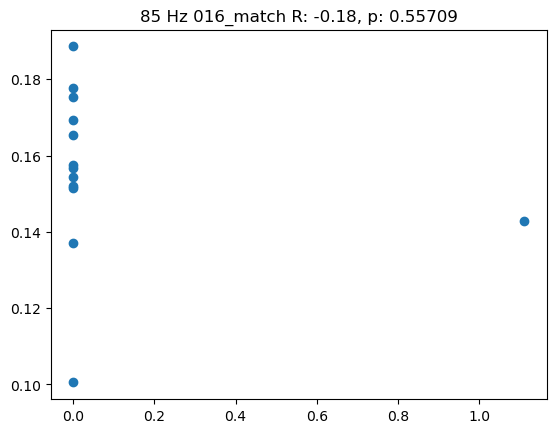

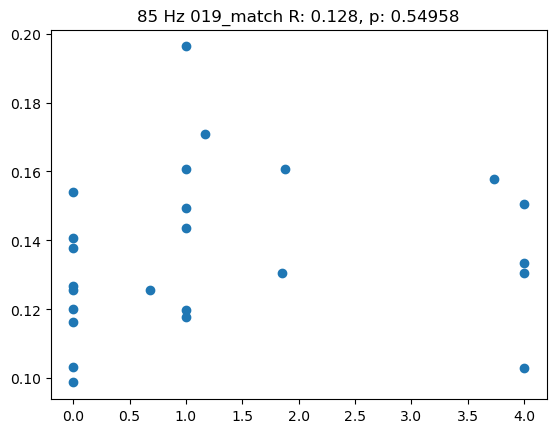

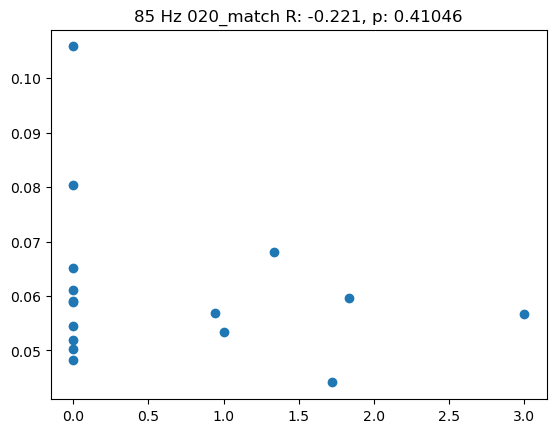

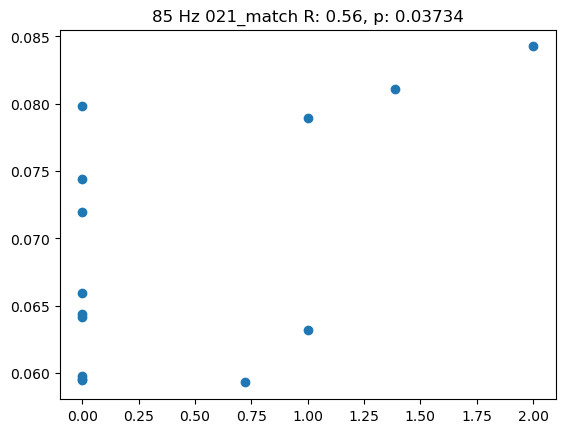

c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [128]:
total_arr, total_f = get_3d_freqCorr_arr(
    datatype='ECOG',
    BLOCK_LEN = BLOCK_SECS,
    DATA_VERSION=DATA_VERSION,
    FT_VERSION=FT_VERSION,
)
ecog_df = get_freqCorr_df(total_3d_arr=total_arr, datatype='ECOG',
                          method=STAT_METHOD, total_freqs=total_f,)

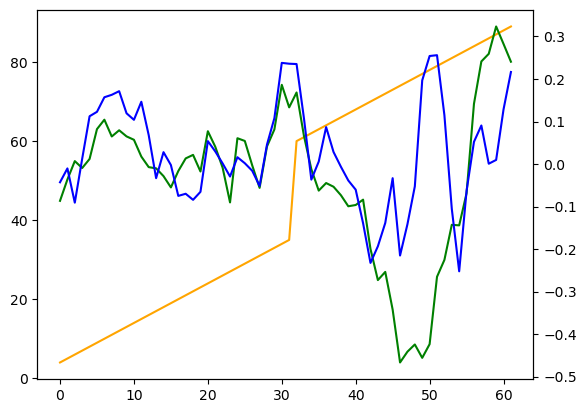

In [160]:
fig, ax = plt.subplots(1,1)

ax.plot(total_f, color='orange')
ax2 = ax.twinx()
ax2.plot(stn_df['R'], color='green')
ax2.plot(ecog_df['R'], color='blue')

In [158]:
importlib.reload(plt_FreqCorr)


freqCorr_dict = {'STN_match': stn_df,
                 'ECOG_match': ecog_df}

plt_FreqCorr.plot_FreqCorr(
    frqCor_values=freqCorr_dict,
    freqs=total_f,
    use_exact_values=True,
    save_dir=os.path.join(get_project_path('figures'),
                          'ft_exploration',
                          f'data_{DATA_VERSION}_ft_{FT_VERSION}',
                          'FreqCorrPlots'),
    fig_name=f'{SAVE_DATE}_FreqCorr_STN_ECoG_CDRSvsPow_{STAT_METHOD}_meanPer{BLOCK_SECS}s')

STN_match color: darkgreen
ECOG_match color: orange
STN_match color: darkgreen
ECOG_match color: orange


In [154]:
FreqCorrs_results['']

{'bi_match': {'R': [[0.9156848483726154,
    0.8804377252900573,
    0.9471486442825963,
    0.861570617214384,
    0.8870795657386527,
    0.8951859276129563,
    0.8571279567210879,
    0.3357125686962018,
    -0.27964271346363617,
    -0.20366626862332196,
    -0.8811178364617354,
    -0.7981435614048753,
    -0.5213481736438262,
    -0.542804577888951,
    -0.42347171574823195,
    -0.3023341983046742,
    0.15814648794086356,
    -0.0918330321898223,
    -0.90793833799581,
    -0.5484881797269525,
    -0.8750114834970928,
    -0.9829244538368933,
    -0.9681324724034794,
    -0.9899321018841187,
    -0.9935396529656969,
    -0.9890065492627182,
    -0.9195470978650041,
    -0.7847774076716816,
    -0.6962019594189945,
    -0.9057480855571287,
    -0.8235762396347693,
    -0.9377776435863635,
    -0.8627775551298618,
    -0.6057923733706742,
    -0.9740837215807054,
    -0.44889814510419707,
    -0.9728388057526065,
    -0.8825355197523104,
    -0.8541023285036763,
    -0.992171650

In [157]:
importlib.reload(plt_FreqCorr)

# calculate Rs
FreqCorrs_results, freqs = plt_FreqCorr.calculate_Rs_FreqCorr(
    FreqCorr_dict=FrqCor, mean_per_score=True,)

# Plot mean Rs per state
plt_FreqCorr.plot_FreqCorr(
    FreqCorrs_results, freqs,
    save_dir=os.path.join(get_project_path('figures'),
                          'ft_exploration',
                          f'data_{DATA_VERSION}_ft_{FT_VERSION}',
                          'FreqCorrPlots'),
    fig_name=f'{SAVE_DATE}_FreqCorr_STN_bilat_CDRS_meanPerScores')

#### Check SSD extraction

In [ ]:
# replicate SSD extraction

importlib.reload(ssd)
# loop over windows

for i_w, win_dat in enumerate(windows.data[:5]):
    win_dat = win_dat.astype(np.float64)    
    # select only rows without missing
    nan_rows = np.array([pd.isna(win_dat[:, i]).any()
                for i in range(win_dat.shape[-1])])
    win_dat = win_dat[:, ~nan_rows]
    win_chnames = list(compress(windows.keys, ~nan_rows))
    win_time = windows.win_starttimes[i_w]
    
    ssds = ssd.SSD_bands_per_window(
        data=win_dat.T, s_rate=windows.fs,
        freq_bands_incl=SETTINGS['SPECTRAL_BANDS'],
    )
 



Phase features to add:
- local PAC from De Hempt (ECoG) (beta-phase, gamma-ampl)
    - EEGLAB ASYMM PAC
    - check calculation via entropy of amplitudes per bin
    - or MI-inde
- phase-phase: CHECK CAGNAN BURST WORK
    - connectivity phase differences from Swann et al (phase-coherence) (angle STN versus angle ECoG, compare with imaginary-coherence)

In [ ]:
import lfpecog_plotting.phase_plotting as phaseplot

In [ ]:
importlib.reload(phaseplot)

### phase difference
# plt.figure(figsize=(12, 4))
# get both signals
sig1 = ssds.lo_beta.copy()
sig2 = ssd0.lo_beta.copy()
# convert to analytic signal
a1 = signal.hilbert(x=sig1,)
a2 = signal.hilbert(x=sig2,)
# get phase from analytical signal, convert from pi to degree
rad1 = np.angle(a1)
deg1 = np.rad2deg(rad1)
rad2 = np.angle(a2)
deg2 = np.rad2deg(rad2)
# get difference, convert all to positive degrees (-90 -> +270)
rad_diff = rad1 - rad2
deg_diff = deg1 - deg2
mask_deg = deg_diff < 0  # bool-array, 0 for values >= 0
mask_rad = rad_diff < 0
corr_rad = np.array([2 * np.pi] * len(rad_diff)) * mask_rad  # corr array is set 0 for pos diff-values
rad_diff += corr_rad
corr_deg = np.array([360] * len(deg_diff)) * mask_deg  # corr array is set 0 for pos diff-values
deg_diff += corr_deg
plt.plot(rad_diff, label='corr', alpha=.8, ls='dotted')
plt.xlim(0, 5000)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(sig1)
plt.plot(sig2)
plt.xlim(0, 5000)
plt.show()

phaseplot.plot_rose_axis(radians=rad_diff)

In [ ]:
sig_phase = ssd_014.ecog_right.lo_beta[10].copy()
sig_ampl = ssd_014.ecog_right.broad_gamma[10].copy()
# sig = ssds.lo_beta.copy()

a_phase = signal.hilbert(x=sig_phase,)
a_ampl = signal.hilbert(x=sig_ampl,)
phase = np.angle(a_phase)
phase_deg = np.rad2deg(phase)  #phase * (180 / np.pi)
ampl = abs(a_ampl)
plt.plot(phase)
plt.plot(ampl)
plt.xlim(0, 1000)
plt.yticks([-np.pi, 0, np.pi],
           labels=['-180', '0', '+180'],)
plt.ylabel('Phase (degree)')
plt.xlabel('time (samples)')
plt.show()



### Calculate PAC

In [ ]:
from tensorpac import Pac
import lfpecog_features.feats_phase_amp_coupling as fts_pac
import lfpecog_features.extract_ssd_features as ssdFts


In [ ]:
SETTINGS = utilsFiles.load_ft_ext_cfg(cfg_fname='ftExtr_spectral_v1.json')

In [ ]:
importlib.reload(phase_fts)

pac_values = fts_pac.calculate_PAC_matrix(
    sig_pha=ssd_014.ecog_right.lo_beta,
    sig_amp=ssd_014.ecog_right.narrow_gamma,
    window_times=ssd_014.ecog_right.times,
    fs=ssd_014.ecog_right.fs,
    freq_range_pha=SETTINGS['SPECTRAL_BANDS']['lo_beta'],
    freq_range_amp=SETTINGS['SPECTRAL_BANDS']['narrow_gamma']
)

### Develop phase-difference values

In [ ]:
phase_deg = phase * (180 / np.pi)

phase_bins = {}
for bin_start in np.arange(-180, 180, 20):
    bin_sel = np.logical_and(phase_deg > bin_start,
                             phase_deg<(bin_start+20))
    ampl_sel = ampl[bin_sel]

    phase_bins[bin_start] = ampl_sel

In [ ]:
for bin in phase_bins:
    amps = phase_bins[bin]
    plt.hist(amps,alpha=.3)
    ent = stats.entropy(amps)
    plt.title(f'{bin} degree: entropy {ent}')
    plt.close()

#### SSD with meet toolbox (https://github.com/neurophysics/meet)

In [ ]:
import meet.meet as meet

In [ ]:
# get data
i_win = 5
win_dat = data.list_mne_objects[i_win].get_data()  # epochs x channels x times
ch_names = data.list_mne_objects[i_win].ch_names
fs = data.info['sfreq']
nperseg = 1024
bw_ranges = {   'alpha': [8, 12],
                'lo_beta': [12, 20],
                'hi_beta': [20, 35],
                'beta': [12, 35],
                'midgamma': [60, 90]}


In [ ]:
from lfpecog_features import feats_SSD as ssd

In [ ]:
# test and plot SSD functionality

importlib.reload(ssd)

SOURCE_SEL = 'ECOG'
F_BAND_SEL = 'midgamma'
epoch_i = 50
plt.close()
# select 2d data of one source (n-channels x n-samples)
ch_sel = [n.startswith(SOURCE_SEL) for n in ch_names]
epoch_dat = win_dat[epoch_i, ch_sel, :]

fig, axes = plt.subplots(3, 1, figsize=(8,8))

for F_BAND_SEL in ['lo_beta', 'hi_beta', 'beta', 'midgamma']:
    ssd_filt_data, ssd_pattern, ssd_eigvals = ssd.get_SSD_component(
        data_2d=epoch_dat,
        fband_interest=bw_ranges[F_BAND_SEL],
        s_rate=fs,
        use_freqBand_filtered=True,
        return_comp_n=0,
    )
    f, psd = signal.welch(ssd_filt_data, axis=-1, nperseg=fs, fs=fs)

    axes[0].plot(ssd_filt_data, label=F_BAND_SEL)
    axes[1].plot(f, psd, label=F_BAND_SEL)

# psd of origin
for i in range(epoch_dat.shape[0]):
    f, psd = signal.welch(epoch_dat[i, :], nperseg=fs, fs=fs)
    axes[2].plot(f, psd, label=F_BAND_SEL, c='k', alpha=.3,)

axes[0].legend(ncol=4)
axes[1].legend()
axes[0].set_title('SSD filtered bands', fontsize=14, weight='bold',)
axes[0].set_ylabel('LFP (a.u.)', fontsize=14,)
axes[0].set_xlabel('Time (samples, 2048 Hz)', fontsize=14,)
axes[1].set_title('Freq-specific PSD after SSD', fontsize=14, weight='bold',)
axes[2].set_title('Original PSDs of channels', fontsize=14, weight='bold',)

for ax in [1, 2]:
    axes[ax].set_xlim(0, 100)
    axes[ax].set_xlabel('Frequency (Hz)', fontsize=14,)
    axes[ax].set_ylabel('Power (a.u.)', fontsize=14,)

for ax in axes: ax.tick_params(axis='both', labelsize=10)
plt.tight_layout()
figname = 'SSD_example_timeseries_PSD'
# plt.savefig(os.path.join(figpath, 'ft_exploration', 'SSD', figname),
#             dpi=300, facecolor='w',)

plt.close()



In [ ]:
# # plot SSD Components
# for i, b in enumerate(SSD_beta):
#     plt.plot(b, label=f'ch {i}',
#              alpha=(1 - (i * .2)),
#              lw=5 - i)
# # beta1d = SSD_beta.T @ np.atleast_2d(SSD_eigvals).T  # combined signal, not relevant
# # plt.plot(beta1d, label='product', c='k')
# plt.legend()
# plt.show()

In [ ]:
d = pd.read_excel('C://Users/habetsj/Downloads/Mappe1.xlsx', header=1)

d = d[[k for k in d.keys() if k.startswith('UPDRS')]]
nan_sel = [~pd.isna(d.values[i]).any() for i in np.arange(d.shape[0])]
d = d.iloc[nan_sel, :].reset_index(drop=True)
str_sel = [any([isinstance(s, str) for s in d.iloc[i]]) for i in np.arange(d.shape[0])]
d = d.iloc[~np.array(str_sel), :].reset_index(drop=True)

plt.scatter(d.iloc[:, 1], d.iloc[:, 0])
plt.xlabel(d.keys()[1])
plt.ylabel(d.keys()[0])

w = stats.wilcoxon(d.iloc[:, 1], d.iloc[:, 0])
p = stats.pearsonr(d.iloc[:, 1], d.iloc[:, 0])
plt.title(f'{p}\n{w}\n(n = {d.shape[0]} PD patients)')
plt.tight_layout()
plt.savefig('C://Users/habetsj/Downloads/Fallzahl_OFF_ON', dpi=150, facecolor='w')
plt.close()

plt.scatter(d.iloc[:, 1], d.iloc[:, 1] - d.iloc[:, 0])
plt.xlabel(d.keys()[1])
plt.ylabel('UPDRS improvement due to Stimulation')

w = stats.wilcoxon(d.iloc[:, 1], d.iloc[:, 1] - d.iloc[:, 0])
p = stats.pearsonr(d.iloc[:, 1], d.iloc[:, 1] - d.iloc[:, 0])
plt.title(f'{p}\n{w}\n(n = {d.shape[0]} PD patients)')
plt.tight_layout()
plt.savefig('C://Users/habetsj/Downloads/Fallzahl_OFF_change', dpi=150, facecolor='w')
plt.close()